In [1]:

import datetime
import numpy as np
import cv2
from itertools import cycle
import pickle
import pathlib
import math
import tqdm
import scipy.io
from matplotlib import pyplot as plt
import scipy.io
import h5py
import re
from lxml import etree as ET
import scipy.signal as sig
import pandas as pd
from scipy.stats import kde
from BlockSync_current import BlockSync
import UtilityFunctions_newOE as uf
from scipy import signal
import bokeh
import seaborn as sns
from matplotlib import rcParams
%matplotlib inline
plt.style.use('default')
rcParams['pdf.fonttype'] = 42  # Ensure fonts are embedded and editable
rcParams['ps.fonttype'] = 42  # Ensure compatibility with vector outputs


def bokeh_plotter(data_list, x_axis_list=None, label_list=None, 
                  plot_name='default',
                  x_axis_label='X', y_axis_label='Y',
                  peaks=None, peaks_list=False, export_path=False):
    """Generates an interactive Bokeh plot for the given data vector.
    Args:
        data_list (list or array): The data to be plotted.
        label_list (list of str): The labels of the data vectors
        plot_name (str, optional): The title of the plot. Defaults to 'default'.
        x_axis (str, optional): The label for the x-axis. Defaults to 'X'.
        y_axis (str, optional): The label for the y-axis. Defaults to 'Y'.
        peaks (list or array, optional): Indices of peaks to highlight on the plot. Defaults to None.
        export_path (False or str): when set to str, will output the resulting html fig
    """
    color_cycle = cycle(bokeh.palettes.Category10_10)
    fig = bokeh.plotting.figure(title=f'bokeh explorer: {plot_name}',
                                x_axis_label=x_axis_label,
                                y_axis_label=y_axis_label,
                                plot_width=1500,
                                plot_height=700)

    for i, data_vector in enumerate(data_list):
        
        color = next(color_cycle)
        
        if x_axis_list is None:
            x_axis = range(len(data_vector))
        elif len(x_axis_list) == len(data_list):
            print('x_axis manually set')
            x_axis = x_axis_list[i]
        else:
            raise Exception('problem with x_axis_list input - should be either None, or a list with the same length as data_list')
        if label_list is None:
            fig.line(x_axis, data_vector, line_color=color, legend_label=f"Line {i+1}")
        elif len(label_list) == len(data_list):
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"{label_list[i]}")
        if peaks is not None and peaks_list is True:
            fig.circle(peaks[i], data_vector[peaks[i]], size=10, color=color)

    if peaks is not None and peaks_list is False:
        fig.circle(peaks, data_vector[peaks], size=10, color='red')

    if export_path is not False:
        print(f'exporting to {export_path}')
        bokeh.io.output.output_file(filename=str(export_path / f'{plot_name}.html'), title=f'{plot_name}')
    bokeh.plotting.show(fig)
    

def load_eye_data_2d_w_rotation_matrix(block):
    """
    This function checks if the eye dataframes and rotation dict object exist, then imports them
    :param block: The current blocksync class with verifiec re/le dfs
    :return: None
    """
    try:
        block.left_eye_data = pd.read_csv(block.analysis_path / 'left_eye_data.csv', index_col=0, engine='python')
        block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data.csv', index_col=0, engine='python')
    except FileNotFoundError:
        print('eye_data files not found, run the pipeline!')
        return
    
    try:
        with open(block.analysis_path / 'rotate_eye_data_params.pkl', 'rb') as file:
            rotation_dict = pickle.load(file)
            block.left_rotation_matrix = rotation_dict['left_rotation_matrix']
            block.right_rotation_matrix = rotation_dict['right_rotation_matrix']
            block.left_rotation_angle = rotation_dict['left_rotation_angle']
            block.right_rotation_angle = rotation_dict['right_rotation_angle']
    except FileNotFoundError:
        print('No rotation matrix file, create it')
    
    
def create_saccade_events_df(eye_data_df, speed_threshold, bokeh_verify_threshold=False, magnitude_calib=1, speed_profile=True):    
    """
    Detects saccade events in eye tracking data and computes relevant metrics.

    Parameters:
    - eye_data_df (pd.DataFrame): Input DataFrame containing eye tracking data.
    - speed_threshold (float): Threshold for saccade detection based on speed.

    Returns:
    - df (pd.DataFrame): Modified input DataFrame with added columns for speed and saccade detection.
    - saccade_events_df (pd.DataFrame): DataFrame containing information about detected saccade events.

    Steps:
    1. Calculate speed components ('speed_x', 'speed_y') based on differences in 'center_x' and 'center_y'.
    2. Compute the magnitude of the velocity vector ('speed_r').
    3. Create a binary column ('is_saccade') indicating saccade events based on the speed threshold.
    4. Determine saccade onset and offset indices and timestamps.
    5. Create a DataFrame ('saccade_events_df') with columns:
        - 'saccade_start_ind': Indices of saccade onset.
        - 'saccade_start_timestamp': Timestamps corresponding to saccade onset.
        - 'saccade_end_ind': Indices of saccade offset.
        - 'saccade_end_timestamp': Timestamps corresponding to saccade offset.
        - 'length': Duration of each saccade event.
    6. Calculate distance traveled and angles for each saccade event.
    7. Append additional columns to 'saccade_events_df':
        - 'magnitude': Magnitude of the distance traveled during each saccade.
        - 'angle': Angle of the saccade vector in degrees.
        - 'initial_x', 'initial_y': Initial coordinates of the saccade.
        - 'end_x', 'end_y': End coordinates of the saccade.

    Note: The original 'eye_data_df' is not modified; modified data is returned as 'df'.
    """
    df = eye_data_df
    df['speed_x'] = df['center_x'].diff()  # Difference between consecutive 'center_x' values
    df['speed_y'] = df['center_y'].diff()  # Difference between consecutive 'center_y' values
    
    # Step 2: Calculate magnitude of the velocity vector (R vector speed)
    df['speed_r'] = (df['speed_x']**2 + df['speed_y']**2)**0.5
    
    # Create a column for saccade detection
    df['is_saccade'] = df['speed_r'] > speed_threshold
    
    # create a saccade_on_off indicator where 1 is rising edge and -1 is falling edge by subtracting a shifted binary mask
    saccade_on_off = df.is_saccade.astype(int) - df.is_saccade.shift(periods=1,fill_value=False).astype(int)
    saccade_on_inds = np.where(saccade_on_off == 1)[0] - 1 # notice the manual shift here, chosen to include the first (sometimes slower) eye frame, just before saccade threshold crossing
    saccade_on_ms = df['ms_axis'].iloc[saccade_on_inds]
    saccade_on_timestamps = df['OE_timestamp'].iloc[saccade_on_inds]
    saccade_off_inds = np.where(saccade_on_off == -1)[0]
    saccade_off_timestamps = df['OE_timestamp'].iloc[saccade_off_inds]
    saccade_off_ms = df['ms_axis'].iloc[saccade_off_inds]
    
    saccade_dict = {'saccade_start_ind' :  saccade_on_inds ,
                    'saccade_start_timestamp': saccade_on_timestamps.values,
                    'saccade_end_ind':      saccade_off_inds,
                    'saccade_end_timestamp':saccade_off_timestamps.values,
                    'saccade_on_ms': saccade_on_ms.values,
                    'saccade_off_ms': saccade_off_ms.values}
    
    saccade_events_df = pd.DataFrame.from_dict(saccade_dict)
    saccade_events_df['length'] = saccade_events_df['saccade_end_ind'] - saccade_events_df['saccade_start_ind']
    # Drop columns used for intermediate steps
    df = df.drop(['is_saccade'], axis=1)
    
    distances = []
    angles = []
    speed_list = []
    diameter_list = []
    for index, row in tqdm.tqdm(saccade_events_df.iterrows()):
        saccade_samples = df.loc[(df['OE_timestamp'] >= row['saccade_start_timestamp']) & 
                                 (df['OE_timestamp'] <= row['saccade_end_timestamp'])]
        distance_traveled = saccade_samples['speed_r'].sum()
        if speed_profile:
            saccade_speed_profile = saccade_samples['speed_r'].values
            speed_list.append(saccade_speed_profile)
        saccade_diameter_profile = saccade_samples['pupil_diameter'].values
        diameter_list.append(saccade_diameter_profile)
        # Calculate angle from initial position to endpoint
        initial_position = saccade_samples.iloc[0][['center_x', 'center_y']]
        endpoint = saccade_samples.iloc[-1][['center_x', 'center_y']]
        overall_angle = np.arctan2(endpoint['center_y'] - initial_position['center_y'],
                           endpoint['center_x'] - initial_position['center_x'])
        
        angles.append(overall_angle)  
        distances.append(distance_traveled)
        
        
    
    saccade_events_df['magnitude_raw'] = np.array(distances)
    saccade_events_df['magnitude'] = np.array(distances) * magnitude_calib
    saccade_events_df['angle'] = np.where(np.isnan(angles), angles, np.rad2deg(angles) % 360) # Convert radians to degrees and ensure result is in [0, 360)
    start_ts = saccade_events_df['saccade_start_timestamp'].values
    end_ts = saccade_events_df['saccade_end_timestamp'].values
    saccade_start_df = df[df['OE_timestamp'].isin(start_ts)]
    saccade_end_df = df[df['OE_timestamp'].isin(end_ts)]
    start_x_coord = saccade_start_df['center_x']
    start_y_coord = saccade_start_df['center_y']
    end_x_coord = saccade_end_df['center_x']
    end_y_coord = saccade_end_df['center_y']
    saccade_events_df['initial_x'] = start_x_coord.values
    saccade_events_df['initial_y'] = start_y_coord.values
    saccade_events_df['end_x'] = end_x_coord.values
    saccade_events_df['end_y'] = end_y_coord.values
    saccade_events_df['calib_dx'] = (saccade_events_df['end_x'].values - saccade_events_df['initial_x'].values) * magnitude_calib
    saccade_events_df['calib_dy'] = (saccade_events_df['end_y'].values - saccade_events_df['initial_y'].values) * magnitude_calib
    if speed_profile:
        saccade_events_df['speed_profile'] = speed_list
    saccade_events_df['diameter_profile'] = diameter_list
    if bokeh_verify_threshold:
        bokeh_plotter(data_list=[df.speed_r], label_list=['Pupil Velocity'], peaks=saccade_on_inds)
        
    return df, saccade_events_df


In [2]:

# create a multi-animal block_collection:

def create_block_collections(animals, block_lists, experiment_path, bad_blocks=None):
    """
    Create block collections and a block dictionary from multiple animals and their respective block lists.

    Parameters:
    - animals: list of str, names of the animals.
    - block_lists: list of lists of int, block numbers corresponding to each animal.
    - experiment_path: pathlib.Path, path to the experiment directory.
    - bad_blocks: list of int, blocks to exclude. Default is an empty list.

    Returns:
    - block_collection: list of BlockSync objects for all specified blocks.
    - block_dict: dictionary where keys are block numbers as strings and values are BlockSync objects.
    """
    import UtilityFunctions_newOE as uf

    if bad_blocks is None:
        bad_blocks = []

    block_collection = []
    block_dict = {}

    for animal, blocks in zip(animals, block_lists):
        # Generate blocks for the current animal
        current_blocks = uf.block_generator(
            block_numbers=blocks,
            experiment_path=experiment_path,
            animal=animal,
            bad_blocks=bad_blocks
        )
        # Add to collection and dictionary
        block_collection.extend(current_blocks)
        for b in current_blocks:
            block_dict[f"{animal}_block_{b.block_num}"] = b

    return block_collection, block_dict


# Example usage:
animals = ['PV_62','PV_126','PV_24','PV_57']
block_lists = [[23,24,26,38],[7,8,9,10,11,12,13],[34],[7,8,9,10,11,12,13]]
experiment_path = pathlib.Path(r"Z:\Nimrod\experiments")
bad_blocks = [0]  # Example of bad blocks

block_collection, block_dict = create_block_collections(
    animals=animals,
    block_lists=block_lists,
    experiment_path=experiment_path,
    bad_blocks=bad_blocks
)

instantiated block number 023 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_023, new OE version
Found the sample rate for block 023 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 023
got it!
instantiated block number 024 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_024, new OE version
Found the sample rate for block 024 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 024
got it!
instantiated block number 026 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_026, new OE version
Found the sample rate for block 026 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 026
got it!
instantiated block number 038 at Path: Z:\Nimrod\experi

In [3]:
for block in block_collection:
    block.parse_open_ephys_events()
    block.get_eye_brightness_vectors()
    block.synchronize_block()
    block.create_eye_brightness_df(threshold_value=20)

    # if the code fails here, go to manual synchronization
    block.import_manual_sync_df()
    block.read_dlc_data()
    block.calibrate_pixel_size(10)
    load_eye_data_2d_w_rotation_matrix(block) #should be integrated again... later
    
    # calibrate pupil diameter:
    if 'pupil_diameter' not in block.left_eye_data.columns:
        block.left_eye_data['pupil_diameter_pixels'] = block.left_eye_data.major_ax * 2 * np.pi
        block.right_eye_data['pupil_diameter_pixels'] = block.right_eye_data.major_ax * 2 * np.pi
        block.left_eye_data['pupil_diameter'] = block.left_eye_data['pupil_diameter_pixels'] * block.L_pix_size
        block.right_eye_data['pupil_diameter'] = block.right_eye_data['pupil_diameter_pixels'] * block.R_pix_size

running parse_open_ephys_events...
block 023 has a parsed events file, reading...
Getting eye brightness values for block 023...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 024 has a parsed events file, reading...
Getting eye brightness values for block 024...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 026 has a parsed events file, reading...
Getting eye brightness values for block 026...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_

c:\users\marks3\pycharmprojects\pythonproject3\venv\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 011 has a parsed events file, reading...
Getting eye brightness values for block 011...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 012 has a parsed events file, reading...
Getting eye brightness values for block 012...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 013 has a parsed events file, reading...
Getting eye brightness values for block 013...
Found an existing 

In [4]:
def create_saccade_events_df_new(
    eye_data_df, speed_threshold, bokeh_verify_threshold=False, magnitude_calib=1, speed_profile=True
):
    """
    Detects saccade events in eye tracking data, computes relevant metrics, and ensures data consistency.

    Parameters:
    - eye_data_df (pd.DataFrame): Input DataFrame containing eye tracking data.
    - speed_threshold (float): Threshold for saccade detection based on speed.
    - bokeh_verify_threshold (bool): Whether to verify the speed threshold using Bokeh plots.
    - magnitude_calib (float): Calibration factor for speed and distance.
    - speed_profile (bool): Whether to compute and store speed profiles.

    Returns:
    - df (pd.DataFrame): Modified input DataFrame with added columns for speed and saccade detection.
    - saccade_events_df (pd.DataFrame): DataFrame containing information about detected saccade events.
    """
    # Copy input DataFrame to avoid modifying it directly
    df = eye_data_df.copy()
    df["speed_x"] = df["center_x"].diff()  # Difference between consecutive 'center_x' values
    df["speed_y"] = df["center_y"].diff()  # Difference between consecutive 'center_y' values

    # Step 2: Calculate magnitude of the velocity vector (R vector speed)
    df["speed_r"] = (df["speed_x"]**2 + df["speed_y"]**2)**0.5

    # Create a column for saccade detection
    df["is_saccade"] = df["speed_r"] > speed_threshold

    # Identify saccade onset and offset indices
    saccade_on_off = df["is_saccade"].astype(int) - df["is_saccade"].shift(periods=1, fill_value=False).astype(int)
    saccade_on_inds = np.where(saccade_on_off == 1)[0] - 1  # Include frame before threshold crossing
    saccade_off_inds = np.where(saccade_on_off == -1)[0]

    # Handle cases where the last saccade has no end
    if len(saccade_on_inds) > len(saccade_off_inds):
        if len(saccade_on_inds) - len(saccade_off_inds) == 1:
            print("Detected unmatched final saccade start index. Truncating last saccade start index.")
            saccade_on_inds = saccade_on_inds[:-1]
        else:
            raise ValueError("Mismatch between saccade start and end indices. Manual inspection required.")

    # Extract timestamps and indices
    saccade_dict = {
        "saccade_start_ind": saccade_on_inds,
        "saccade_start_timestamp": df["OE_timestamp"].iloc[saccade_on_inds].values,
        "saccade_end_ind": saccade_off_inds,
        "saccade_end_timestamp": df["OE_timestamp"].iloc[saccade_off_inds].values,
        "saccade_on_ms": df["ms_axis"].iloc[saccade_on_inds].values,
        "saccade_off_ms": df["ms_axis"].iloc[saccade_off_inds].values,
    }

    # Ensure all lists have consistent lengths
    valid_mask = np.all(
        [
            len(saccade_dict[field]) == len(saccade_dict["saccade_start_ind"])
            for field in saccade_dict
        ]
    )
    if not valid_mask:
        valid_lengths = {key: len(value) for key, value in saccade_dict.items()}
        print(f"Detected inconsistent lengths in saccade fields: {valid_lengths}")
        raise ValueError("Fields in saccade dictionary must all have equal lengths.")

    saccade_events_df = pd.DataFrame.from_dict(saccade_dict)
    saccade_events_df["length"] = saccade_events_df["saccade_end_ind"] - saccade_events_df["saccade_start_ind"]

    # Compute saccade metrics
    distances = []
    angles = []
    speed_list = []
    speed_list_calib = []
    diameter_list = []

    for _, row in tqdm.tqdm(saccade_events_df.iterrows(), total=len(saccade_events_df)):
        saccade_samples = df.loc[
            (df["OE_timestamp"] >= row["saccade_start_timestamp"])
            & (df["OE_timestamp"] <= row["saccade_end_timestamp"])
        ]
        if saccade_samples.empty:
            continue

        # Distance traveled
        distance_traveled = saccade_samples["speed_r"].sum()
        distances.append(distance_traveled)

        # Speed profile
        if speed_profile:
            saccade_speed_profile = saccade_samples["speed_r"].values
            saccade_calib_speed_profile = saccade_speed_profile * magnitude_calib
            speed_list.append(saccade_speed_profile)
            speed_list_calib.append(saccade_calib_speed_profile)

        # Diameter profile
        saccade_diameter_profile = saccade_samples["pupil_diameter"].values
        diameter_list.append(saccade_diameter_profile)

        # Calculate angle
        initial_position = saccade_samples.iloc[0][["center_x", "center_y"]]
        endpoint = saccade_samples.iloc[-1][["center_x", "center_y"]]
        overall_angle = np.arctan2(
            endpoint["center_y"] - initial_position["center_y"],
            endpoint["center_x"] - initial_position["center_x"]
        )
        angles.append(overall_angle)

    # Add metrics to DataFrame
    saccade_events_df["magnitude_raw"] = np.array(distances)
    saccade_events_df["magnitude"] = np.array(distances) * magnitude_calib
    saccade_events_df["angle"] = np.rad2deg(angles) % 360  # Convert radians to degrees
    saccade_events_df["speed_profile"] = speed_list
    saccade_events_df["speed_profile_calib"] = speed_list_calib
    saccade_events_df["diameter_profile"] = diameter_list

    # Remove intermediate columns from df
    df = df.drop(["is_saccade"], axis=1)

    # Optional: Verify using Bokeh plot
    if bokeh_verify_threshold:
        bokeh_plotter(data_list=[df.speed_r], label_list=["Pupil Velocity"], peaks=saccade_on_inds)

    return df, saccade_events_df

In [5]:
# saccade detection and annotation: 
for block in block_collection:
    print(block)
    block.left_eye_data, block.l_saccade_df = create_saccade_events_df_new(block.left_eye_data,
                                                               speed_threshold=4,
                                                               bokeh_verify_threshold=False,
                                                               magnitude_calib=block.L_pix_size)
    block.right_eye_data, block.r_saccade_df = create_saccade_events_df_new(block.right_eye_data,
                                                               speed_threshold=4,
                                                               bokeh_verify_threshold=False,
                                                               magnitude_calib=block.R_pix_size)


 11%|█▏        | 68/602 [00:00<00:00, 677.90it/s]

PV_62, block 023, on 2023-04-27_10-52-42


 23%|██▎       | 138/602 [00:00<00:00, 692.55it/s]

PV_62, block 024, on 2023-04-27_11-22-56


 11%|█         | 66/598 [00:00<00:00, 658.10it/s]

PV_62, block 026, on 2023-04-27_12-21-41


  6%|▌         | 63/1126 [00:00<00:01, 628.68it/s]

PV_62, block 038, on 2023-05-01_13-57-45


  6%|▌         | 67/1209 [00:00<00:01, 665.66it/s]

PV_126, block 007, on PV126_Trial16_wake3_2024-07-18_12-49-12


 16%|█▋        | 60/366 [00:00<00:00, 597.68it/s]

PV_126, block 008, on PV126_Trial16_wake4_2024-07-18_13-24-41


 18%|█▊        | 66/359 [00:00<00:00, 659.20it/s]

PV_126, block 009, on PV126_Trial18_wake5_2024-07-18_14-39-15


 27%|██▋       | 65/245 [00:00<00:00, 647.70it/s]

PV_126, block 010, on PV126_Trial19_wake6_2024-07-18_15-24-57


  7%|▋         | 67/1009 [00:00<00:01, 667.31it/s]

PV_126, block 011, on PV126_Trial115_eyeTracking_w7


  0%|          | 0/129 [00:00<?, ?it/s]

PV_126, block 012, on PV126_Trial116_eyeTracking_h8


  0%|          | 0/77 [00:00<?, ?it/s]

PV_126, block 013, on PV126_Trial116_eyeTracking_h9


 10%|█         | 71/700 [00:00<00:00, 702.30it/s]

PV_24, block 034, on PV24_30_12_21_EE34_2021-12-30_12-30-47


 22%|██▏       | 148/672 [00:00<00:00, 740.05it/s]

PV_57, block 007, on pv_57_day2_03_2024-11-25_15-28-31


 11%|█         | 71/638 [00:00<00:00, 707.48it/s]

PV_57, block 008, on pv_57_day2_05_2024-11-25_16-07-18


 14%|█▍        | 71/502 [00:00<00:00, 702.17it/s]

PV_57, block 009, on pv_57_day2_06_2024-11-25_16-25-35


 20%|██        | 71/352 [00:00<00:00, 698.48it/s]

PV_57, block 010, on PV_57_hunter__2024-12-01_15-37-36


  7%|▋         | 70/954 [00:00<00:01, 696.53it/s]

PV_57, block 011, on PV_57_hunter_2_2024-12-01_15-43-28
Detected unmatched final saccade start index. Truncating last saccade start index.


 12%|█▏        | 73/589 [00:00<00:00, 729.99it/s]

PV_57, block 012, on PV_57_hunter_2_2024-12-01_16-08-39


 10%|▉         | 72/737 [00:00<00:00, 718.81it/s]

PV_57, block 013, on PV_57_hunter_2_2024-12-01_16-34-43


100%|██████████| 725/725 [00:00<00:00, 746.08it/s]


In [10]:
### over here, I get the lizard movements binary from mark's analysis
import os
def block_get_lizard_movement(block):
    # collect accelerometer data
    # path definition
    p = block.oe_path / 'analysis'
    analysis_list = os.listdir(p)
    correct_analysis = [i for i in analysis_list if block.animal_call in i][0]
    p = p / str(correct_analysis)
    mat_path = p / 'lizMov.mat'
    print(f'path to mat file is {mat_path}')
    # read mat file
    try:
        mat_data = h5py.File(str(mat_path), 'r')
        mat_dict = {'t_mov_ms': mat_data['t_mov_ms'][:],
                    'movAll': mat_data['movAll'][:]}
        
        acc_df = pd.DataFrame(data=np.array([mat_dict['t_mov_ms'][:, 0], mat_dict['movAll'][:, 0]]).T,
                              columns=['t_mov_ms', 'movAll'])
        mat_data.close()
        block.liz_mov_df = acc_df
        print(f'liz_mov_df created for {block}')
    except FileNotFoundError:
        print('mat file does not exist - run the matlab getLizMovement function')
        
    return

for block in block_collection:
    block_get_lizard_movement(block)

# this cell now labels the saccades as with/without head movements
def get_head_mov_col(df, mov_times):
    head_mov_bool = np.zeros(len(df), dtype=bool)  # Initialize array of False

    for i, saccade in enumerate(df.itertuples()):
        saccade_start = saccade.saccade_on_ms
        saccade_end = saccade.saccade_off_ms
        
        overlapping_mov_times = mov_times[np.logical_and(mov_times >= saccade_start, mov_times <= saccade_end)]
        
        if overlapping_mov_times.size > 0:  
            head_mov_bool[i] = True

    df['head_movement'] = head_mov_bool
    return df

def label_saccade_movements(block):
    mov_times = block.liz_mov_df.t_mov_ms.values
    block.l_saccade_df = get_head_mov_col(block.l_saccade_df,mov_times=mov_times)
    block.r_saccade_df = get_head_mov_col(block.r_saccade_df,mov_times=mov_times)

for block in block_collection:
    label_saccade_movements(block)


path to mat file is Z:\Nimrod\experiments\PV_62\2023_04_27\block_023\oe_files\2023-04-27_10-52-42\Record Node 108\analysis\recNames=Block0023,Animal=PV_62\lizMov.mat
liz_mov_df created for PV_62, block 023, on 2023-04-27_10-52-42
path to mat file is Z:\Nimrod\experiments\PV_62\2023_04_27\block_024\oe_files\2023-04-27_11-22-56\Record Node 108\analysis\recNames=Block0024,Animal=PV_62\lizMov.mat
liz_mov_df created for PV_62, block 024, on 2023-04-27_11-22-56
path to mat file is Z:\Nimrod\experiments\PV_62\2023_04_27\block_026\oe_files\2023-04-27_12-21-41\Record Node 108\analysis\recNames=Block0026,Animal=PV_62\lizMov.mat
liz_mov_df created for PV_62, block 026, on 2023-04-27_12-21-41
path to mat file is Z:\Nimrod\experiments\PV_62\2023_05_01\block_038\oe_files\2023-05-01_13-57-45\Record Node 108\analysis\recNames=Block0038,Animal=PV_62\lizMov.mat
liz_mov_df created for PV_62, block 038, on 2023-05-01_13-57-45
path to mat file is Z:\Nimrod\experiments\PV_126\2024_07_18\block_007\oe_files\P

OSError: Unable to open file (file signature not found)

In [6]:
# add annotations for a joint dataframe:
for block in block_collection:
    block.r_saccade_df['eye'] = 'R'
    block.r_saccade_df['block'] = block.block_num
    block.r_saccade_df['animal'] = block.animal_call
    block.l_saccade_df['eye'] = 'L'
    block.l_saccade_df['block'] = block.block_num
    block.l_saccade_df['animal'] = block.animal_call
    block.all_saccade_df = pd.concat([block.l_saccade_df,block.r_saccade_df])

In [7]:
saccade_df_list = []
for block in block_collection:
    saccade_df_list.append(block.all_saccade_df)
saccade_collection = pd.concat(saccade_df_list)

In [8]:
def get_closest_diff_ind(timestamp, timeseries):
    """
    This function extracts a frame from a series so that it is as close as possible to a given timestamp
    :param timestamp: The time to match a frame to
    :param timeseries: The time frames series to look at for a match
    :param report_acc: if set to 1, will report the accuracy of the match
    :return: index_of_lowest_diff , accuracy of match (if requested)
    """
    array = np.abs(timeseries - timestamp)
    index_of_lowest_diff = np.argmin(array)
    lowest_diff_val = timeseries[index_of_lowest_diff]
    return index_of_lowest_diff, lowest_diff_val

def find_synced_saccades(df, diff_threshold=680):
    synced_saccades = []
    non_synced_saccades = []
    l_df = df.query('eye == "L"')
    r_df = df.query('eye == "R"')
    for i, row in tqdm.tqdm(l_df.iterrows()):
        l_timestamp = row['saccade_start_timestamp']
        ind_min_diff, r_timestamp = get_closest_diff_ind(l_timestamp, r_df['saccade_start_timestamp'].values)
        #print(i,ind_lowest_diff)
        time_diff = np.abs(l_timestamp - r_timestamp)
        if time_diff < diff_threshold:
            synced_saccades.append((row, r_df.iloc[ind_min_diff]))  # Collect synchronized rows
        else:
            non_synced_saccades.append(row)  # Collect non-synchronized rows
    # Create DataFrame with multi-index
    multi_index = pd.MultiIndex.from_tuples([(i, 'L') for i in range(len(synced_saccades))] + [(i, 'R') for i in range(len(synced_saccades))], names=['Main', 'Sub'])
    synced_df = pd.DataFrame(index=multi_index, columns=df.columns)
    # Populate DataFrame
    for idx, (l_row, r_row) in enumerate(synced_saccades):
        synced_df.loc[(idx, 'L')] = l_row
        synced_df.loc[(idx, 'R')] = r_row
    r_non_synced_leftovers = r_df[~r_df['saccade_start_timestamp'].isin(synced_df.query('eye == "R"')['saccade_start_timestamp'].values)]
    print(len(r_non_synced_leftovers),len(r_df))
    # Create DataFrame for non-synced saccades
    non_synced_df = pd.DataFrame(non_synced_saccades, columns=df.columns)
    non_synced_df = pd.concat([non_synced_df,r_non_synced_leftovers])
    
    return synced_df, non_synced_df

synced_df_list = []
non_synced_df_list = []
for saccade_df in saccade_df_list:
    # Find synced saccades:
    synced_df, non_synced_df = find_synced_saccades(saccade_df.dropna(), diff_threshold=680)
    if len(non_synced_df.dropna()) + len(synced_df.dropna()) == len(saccade_df.dropna()):
        print('got them all')
        
    synced_df_list.append(synced_df)
    non_synced_df_list.append(non_synced_df)


577it [00:00, 7097.84it/s]
577it [00:00, 7124.48it/s]
0it [00:00, ?it/s]

199 568
199 568


575it [00:00, 7144.94it/s]
1034it [00:00, 8117.01it/s]


190 547


1163it [00:00, 6833.02it/s]
341it [00:00, 7272.89it/s]
338it [00:00, 6922.81it/s]

599 1064
342 1110
181 386



230it [00:00, 6976.15it/s]
0it [00:00, ?it/s]

204 414
129 273


961it [00:00, 5070.82it/s]
107it [00:00, 6814.93it/s]
77it [00:00, 6900.15it/s]
687it [00:00, 8424.81it/s]

366 988
50 123
19 75
got them all



669it [00:00, 8124.64it/s]
0it [00:00, ?it/s]

313 598
322 648


630it [00:00, 7345.79it/s]
489it [00:00, 7956.21it/s]
348it [00:00, 7058.11it/s]

209 563
271 510



926it [00:00, 7381.94it/s]


157 390


581it [00:00, 7465.35it/s]
0it [00:00, ?it/s]

337 868
144 463


706it [00:00, 6836.26it/s]


280 694


In [9]:
def combine_synced_dataframes(dataframes):
    combined_dfs = []
    start_index = 0
    for df in dataframes:
        num_rows = len(df) // 2  # Assuming each dataframe contains pairs of rows
        main_index = pd.MultiIndex.from_tuples([(i + start_index, 'L') for i in range(num_rows)] + [(i + start_index, 'R') for i in range(num_rows)], names=['Main', 'Sub'])
        df.index = main_index
        combined_dfs.append(df)
        start_index += num_rows
    combined_df = pd.concat(combined_dfs)
    combined_df.reset_index(inplace=True)
    return combined_df

synced_saccade_collection = combine_synced_dataframes(synced_df_list)
non_synced_saccade_collection = pd.concat(non_synced_df_list)


Exported plot and data to: Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\average_saccade_amplitude_histogram\saccade_amplitude_averaged_histogram_2025_01_04_23_03_37


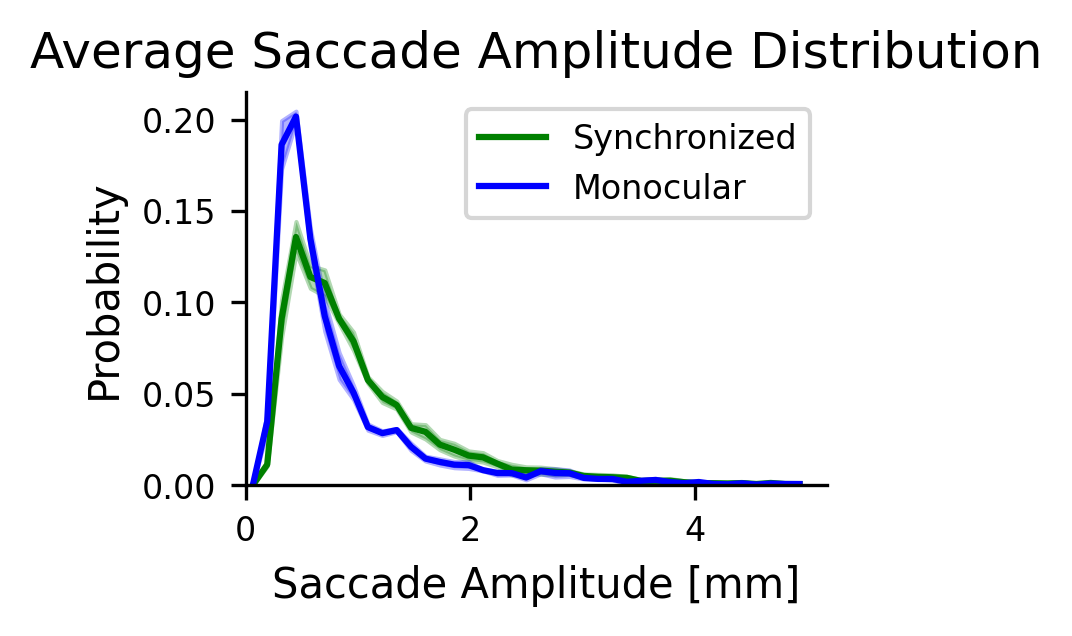

In [15]:
def plot_averaged_saccade_amplitude_distribution(
    synced_saccade_collection, non_synced_saccade_collection, figure_size=(2.5, 1.7), export_path=None
):
    """
    Plots the average saccade amplitude likelihood histogram across animals, showing only the outline of the distributions.

    Parameters:
    - synced_saccade_collection (pd.DataFrame): DataFrame containing synced saccade data with an 'animal' column.
    - non_synced_saccade_collection (pd.DataFrame): DataFrame containing non-synced saccade data with an 'animal' column.
    - figure_size (tuple): Size of the figure for the plot.
    - export_path (str or pathlib.Path, optional): Path to save the plot and data. Defaults to None.
    """
    # Define bins
    bins = np.linspace(0, 5, 40)
    bin_centers = (bins[:-1] + bins[1:]) / 2  # Arithmetic mean for linear bins

    # Group by animals
    animals = synced_saccade_collection['animal'].unique()
    num_animals = len(animals)

    # Store normalized histograms for synced and non-synced data
    synced_likelihoods = []
    non_synced_likelihoods = []

    for animal in animals:
        # Filter data for this animal
        synced_data = synced_saccade_collection.query("animal == @animal")['magnitude'].values
        non_synced_data = non_synced_saccade_collection.query("animal == @animal")['magnitude'].values

        # Calculate histograms (normalized to probabilities)
        synced_hist, _ = np.histogram(synced_data, bins=bins)
        non_synced_hist, _ = np.histogram(non_synced_data, bins=bins)

        synced_hist = synced_hist / synced_hist.sum() if synced_hist.sum() > 0 else synced_hist
        non_synced_hist = non_synced_hist / non_synced_hist.sum() if non_synced_hist.sum() > 0 else non_synced_hist

        synced_likelihoods.append(synced_hist)
        non_synced_likelihoods.append(non_synced_hist)

    # Convert to arrays for calculations
    synced_likelihoods = np.array(synced_likelihoods)
    non_synced_likelihoods = np.array(non_synced_likelihoods)

    # Calculate mean and SEM
    synced_mean = synced_likelihoods.mean(axis=0)
    synced_sem = synced_likelihoods.std(axis=0) / np.sqrt(num_animals)

    non_synced_mean = non_synced_likelihoods.mean(axis=0)
    non_synced_sem = non_synced_likelihoods.std(axis=0) / np.sqrt(num_animals)

    # Plot averaged histograms
    fig, ax = plt.subplots(figsize=figure_size, dpi=300)

    # Plot outlines for synced data
    ax.plot(
        bin_centers,
        synced_mean,
        color='green',
        linestyle='-',
        linewidth=1.5,
        label='Synchronized'
    )
    ax.fill_between(
        bin_centers,
        synced_mean - synced_sem,
        synced_mean + synced_sem,
        color='green',
        alpha=0.3
    )

    # Plot outlines for non-synced data
    ax.plot(
        bin_centers,
        non_synced_mean,
        color='blue',
        linestyle='-',
        linewidth=1.5,
        label='Monocular'
    )
    ax.fill_between(
        bin_centers,
        non_synced_mean - non_synced_sem,
        non_synced_mean + non_synced_sem,
        color='blue',
        alpha=0.3
    )

    # Customize the plot
    ax.set_title('Average Saccade Amplitude Distribution', fontsize=12)
    ax.set_xlabel('Saccade Amplitude [mm]', fontsize=10)
    ax.set_ylabel('Probability', fontsize=10)
    ax.legend(fontsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)

    # Handle export
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"saccade_amplitude_averaged_histogram_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)

        # Save plot
        pdf_file = os.path.join(full_export_path, "saccade_amplitude_averaged_histogram.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)

        # Save data
        data_file = os.path.join(full_export_path, "averaged_saccade_amplitude_data.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump(
                {
                    'synced_mean': synced_mean,
                    'synced_sem': synced_sem,
                    'non_synced_mean': non_synced_mean,
                    'non_synced_sem': non_synced_sem,
                    'bins': bins,
                },
                f
            )

        print(f"Exported plot and data to: {full_export_path}")

    plt.show()


export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\average_saccade_amplitude_histogram'
plot_averaged_saccade_amplitude_distribution(synced_saccade_collection, non_synced_saccade_collection, figure_size=(2.5, 1.7), export_path=export_path)

100%|██████████| 10000/10000 [00:15<00:00, 650.74it/s]


Observed Stat: 0.16866721145320085
P-Value: 0.0


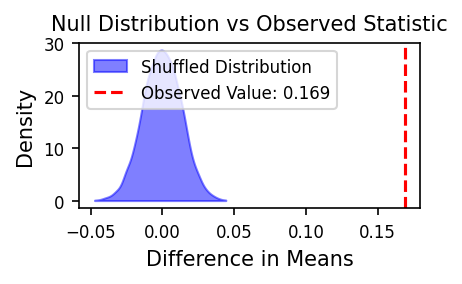

In [17]:
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

def monte_carlo_shuffle_test_amplitudes(
    synced_saccade_collection, non_synced_saccade_collection, n_permutations=10000
):
    """
    Performs a Monte Carlo shuffle test to compare the mean amplitudes of synchronized
    and monocular saccades.

    Parameters:
    - synced_saccade_collection (pd.DataFrame): DataFrame containing synchronized saccades.
    - non_synced_saccade_collection (pd.DataFrame): DataFrame containing monocular saccades.
    - n_permutations (int): Number of random shuffles.

    Returns:
    - result_dict (dict): Contains observed statistic, null distribution, and p-value.
    """
    # Extract magnitudes
    synced_amplitudes = synced_saccade_collection['magnitude'].values
    non_synced_amplitudes = non_synced_saccade_collection['magnitude'].values

    # Combine data and labels
    all_amplitudes = np.concatenate([synced_amplitudes, non_synced_amplitudes])
    labels = np.array([0] * len(synced_amplitudes) + [1] * len(non_synced_amplitudes))

    # Observed statistic: difference in means
    observed_stat = np.mean(synced_amplitudes) - np.mean(non_synced_amplitudes)

    # Generate null distribution
    null_distribution = []
    for _ in tqdm.tqdm(range(n_permutations)):
        np.random.shuffle(labels)  # Shuffle labels
        shuffled_synced = all_amplitudes[labels == 0]
        shuffled_non_synced = all_amplitudes[labels == 1]
        shuffled_stat = np.mean(shuffled_synced) - np.mean(shuffled_non_synced)
        null_distribution.append(shuffled_stat)

    null_distribution = np.array(null_distribution)

    # Calculate p-value
    p_value = np.mean(np.abs(null_distribution) >= np.abs(observed_stat))

    # Return results
    return {
        "observed_stat": observed_stat,
        "null_distribution": null_distribution,
        "p_value": p_value,
    }

def plot_null_distribution(result_dict):
    """
    Visualize the null distribution and observed statistic.

    Args:
        result_dict (dict): Output from the Monte Carlo calculation function.
                            Must contain "observed_stat" and "null_distribution".
    """
    observed_stat = result_dict["observed_stat"]
    null_dist = result_dict["null_distribution"]

    # Create the figure
    fig, ax = plt.subplots(figsize=(3, 2), dpi=150)

    # Density estimation for the null distribution
    kde = gaussian_kde(null_dist)
    x_vals = np.linspace(min(null_dist), max(null_dist), 500)
    y_vals = kde(x_vals)

    # Plot shaded null distribution
    ax.fill_between(x_vals, y_vals, color='blue', alpha=0.5, label='Shuffled Distribution')

    # Mark the observed statistic
    ax.axvline(observed_stat, color='red', linestyle='--', label=f'Observed Value: {observed_stat:.3f}')

    # Customize plot aesthetics
    ax.set_title("Null Distribution vs Observed Statistic", fontsize=10)
    ax.set_xlabel("Difference in Means", fontsize=10)
    ax.set_ylabel("Density", fontsize=10)
    ax.tick_params(axis='both', labelsize=8)
    ax.legend(fontsize=8)

    # Display plot
    plt.tight_layout()
    plt.show()

# Example Usage
result = monte_carlo_shuffle_test_amplitudes(
    synced_saccade_collection=synced_saccade_collection,
    non_synced_saccade_collection=non_synced_saccade_collection,
    n_permutations=10000
)

print(f"Observed Stat: {result['observed_stat']}")
print(f"P-Value: {result['p_value']}")
plot_null_distribution(result)


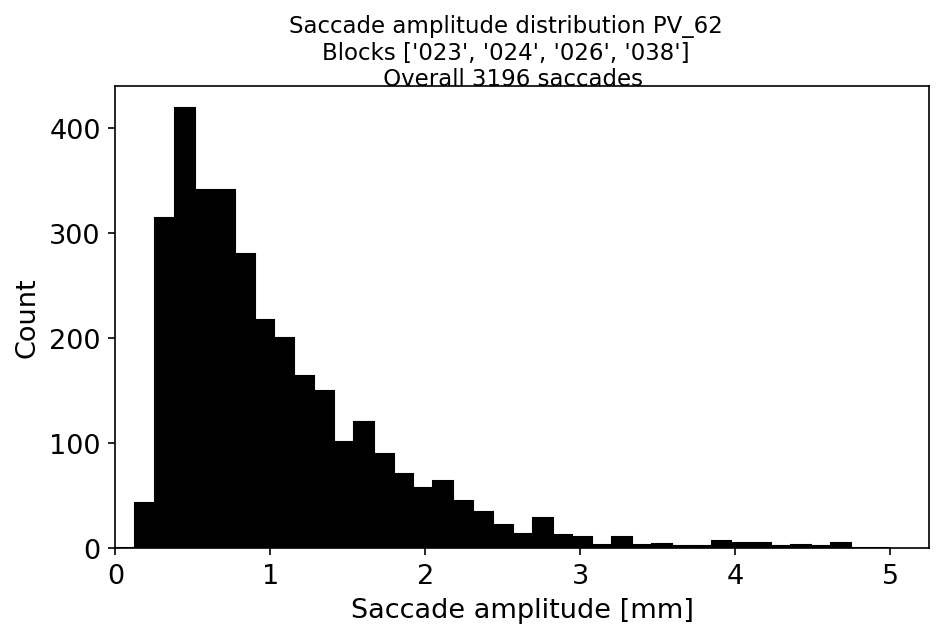

In [15]:
from scipy.stats import poisson
# make a histogram plot for all saccade magnitudes (L/R):
#all_magnitudes_mm = np.hstack([block.l_saccade_df['magnitude'].values * block.L_pix_size, block.r_saccade_df['magnitude'].values * block.R_pix_size])
all_magnitudes_mm = synced_saccade_collection['magnitude'].values
# Create the figure and axis
fig, ax = plt.subplots(figsize=(7, 4), dpi=150)

# Plot the histogram
ax.hist(all_magnitudes_mm,bins=np.linspace(0,5,40),log=True, color='black', edgecolor='black')

# Set title and labels
title = (f'Saccade amplitude distribution {block.animal_call} \n'
         f'Blocks {[b.block_num for b in block_collection]} \n '
         f'Overall {len(all_magnitudes_mm)} saccades')
fig.suptitle(title, fontsize=11, y=1)

ax.set_xlabel('Saccade amplitude [mm]', fontsize=13)
ax.set_xscale('linear')
ax.set_yscale('linear')
ax.set_ylabel('Count', fontsize=13)

# Adjust tick label sizes
ax.tick_params(axis='both', which='major', labelsize=13)

# Set white background and black text
fig.patch.set_facecolor('white')
ax.set_facecolor('white')
#ax.set_facecolor('white')
ax.title.set_color('black')
ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')

# Set the x-axis to start precisely at 0
ax.set_xlim(left=0)
ax.tick_params(colors='black')



t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
#plt.savefig(rf'D:\MarkS3\Pictures\Graphs\2024_Head_mounted_eyecam_system\Current_Paradigm\PV_126\{t}_Saccade_amplitude_distribution_synced.pdf', format='pdf')
plt.show()

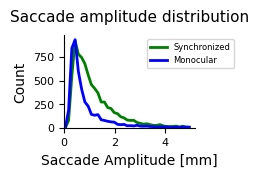

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
import pickle

def plot_saccade_amplitude_distribution(synced_saccade_collection, non_synced_saccade_collection, export_path=None):
    # Extract magnitudes from both collections
    synced_magnitudes = synced_saccade_collection['magnitude'].values
    non_synced_magnitudes = non_synced_saccade_collection['magnitude'].values

    # Define bins
    bins = np.linspace(0, 5, 40)

    # Calculate histograms for both distributions
    synced_hist, _ = np.histogram(synced_magnitudes, bins=bins)
    non_synced_hist, _ = np.histogram(non_synced_magnitudes, bins=bins)

    # Calculate bin centers
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(1.7, 1.2), dpi=100)

    # Plot the histograms as lines
    ax.plot(bin_centers, synced_hist, label='Synchronized', color='green', linewidth=2)
    ax.plot(bin_centers, non_synced_hist, label='Monocular', color='blue', linewidth=2)

    # Set labels and title
    ax.set_title("Saccade amplitude distribution", fontsize=11, pad=10)
    ax.set_xlabel('Saccade Amplitude [mm]', fontsize=10)
    ax.set_ylabel('Count', fontsize=10)

    # Adjust tick label sizes
    ax.tick_params(axis='both', which='major', labelsize=8)

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Set background colors and axis limits
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)
    ax.tick_params(colors='black')

    # Add a legend
    ax.legend(loc='center left', bbox_to_anchor=(0.6, 0.8), fontsize=6)
    # Handle export if export_path is provided
    if export_path is not None:
        # Create a timestamped folder
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"saccade_plot_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)

        # Save plot as PDF
        pdf_file = os.path.join(full_export_path, "saccade_amplitude_distribution.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight')

        # Save DataFrames using pickle
        data_file = os.path.join(full_export_path, "saccade_collections.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump({
                "synced_saccade_collection": synced_saccade_collection,
                "non_synced_saccade_collection": non_synced_saccade_collection
            }, f)

        print(f"Exported plot and data to: {full_export_path}")

    plt.show()
export_path = pathlib.Path(r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\saccade_amplitude_histograms')
plot_saccade_amplitude_distribution(synced_saccade_collection,non_synced_saccade_collection,export_path=None)

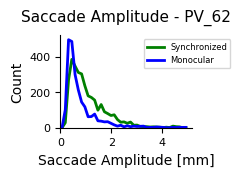

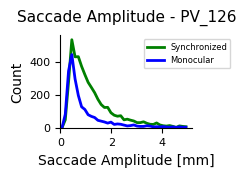

In [12]:
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pickle

def plot_saccade_amplitude_per_animal(synced_saccade_collection, non_synced_saccade_collection, export_path=None):
    """
    Plots saccade amplitude distribution for each animal using the `animal` column in the input dataframes.

    Parameters:
        synced_saccade_collection (pd.DataFrame): DataFrame containing synced saccade data with an 'animal' column.
        non_synced_saccade_collection (pd.DataFrame): DataFrame containing non-synced saccade data with an 'animal' column.
        export_path (str or pathlib.Path, optional): Path to save the plots. Defaults to None.
    """
    # Extract unique animals
    animals = synced_saccade_collection['animal'].unique()

    bins = np.linspace(0, 5, 40)  # Define bins

    for animal in animals:
        # Filter data for this animal
        synced_data = synced_saccade_collection.query("animal == @animal")['magnitude'].values
        non_synced_data = non_synced_saccade_collection.query("animal == @animal")['magnitude'].values

        # Calculate histograms
        synced_hist, _ = np.histogram(synced_data, bins=bins)
        non_synced_hist, _ = np.histogram(non_synced_data, bins=bins)
        bin_centers = (bins[:-1] + bins[1:]) / 2

        # Create the figure and axis
        fig, ax = plt.subplots(figsize=(1.7, 1.2), dpi=100)

        # Plot the histograms
        ax.plot(bin_centers, synced_hist, label='Synchronized', color='green', linewidth=2)
        ax.plot(bin_centers, non_synced_hist, label='Monocular', color='blue', linewidth=2)

        # Set labels and title
        ax.set_title(f"Saccade Amplitude - {animal}", fontsize=11, pad=10)
        ax.set_xlabel('Saccade Amplitude [mm]', fontsize=10)
        ax.set_ylabel('Count', fontsize=10)

        # Adjust tick label sizes
        ax.tick_params(axis='both', which='major', labelsize=8)

        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # Set background colors and axis limits
        fig.patch.set_facecolor('white')
        ax.set_facecolor('white')
        ax.set_xlim(left=0)
        ax.set_ylim(bottom=0)
        ax.tick_params(colors='black')

        # Add a legend
        ax.legend(loc='center left', bbox_to_anchor=(0.6, 0.8), fontsize=6)

        # Handle export if export_path is provided
        if export_path is not None:
            animal_export_path = os.path.join(export_path, animal)
            os.makedirs(animal_export_path, exist_ok=True)

            # Save plot as PDF
            pdf_file = os.path.join(animal_export_path, f"saccade_amplitude_{animal}.pdf")
            fig.savefig(pdf_file, format='pdf', bbox_inches='tight')

        plt.show()
plot_saccade_amplitude_per_animal(synced_saccade_collection, non_synced_saccade_collection, export_path=None)

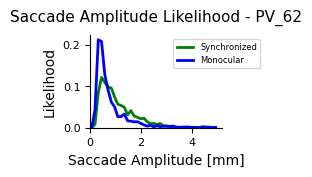

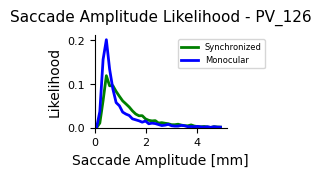

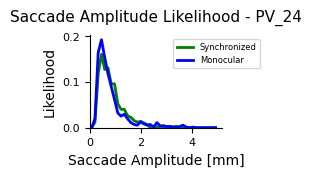

In [9]:
import os
import matplotlib.pyplot as plt
import numpy as np

def plot_saccade_amplitude_per_animal(synced_saccade_collection, non_synced_saccade_collection, export_path=None):
    """
    Plots saccade amplitude likelihood distributions for each animal using the `animal` column in the input dataframes.

    Parameters:
        synced_saccade_collection (pd.DataFrame): DataFrame containing synced saccade data with an 'animal' column.
        non_synced_saccade_collection (pd.DataFrame): DataFrame containing non-synced saccade data with an 'animal' column.
        export_path (str or pathlib.Path, optional): Path to save the plots. Defaults to None.
    """
    # Extract unique animals
    animals = synced_saccade_collection['animal'].unique()

    bins = np.linspace(0, 5, 40)  # Define bins

    for animal in animals:
        # Filter data for this animal
        synced_data = synced_saccade_collection.query("animal == @animal")['magnitude'].values
        non_synced_data = non_synced_saccade_collection.query("animal == @animal")['magnitude'].values

        # Calculate likelihood distributions
        synced_hist, _ = np.histogram(synced_data, bins=bins)
        non_synced_hist, _ = np.histogram(non_synced_data, bins=bins)
        synced_likelihood = synced_hist / np.sum(synced_hist)  # Normalize to sum to 1
        non_synced_likelihood = non_synced_hist / np.sum(non_synced_hist)  # Normalize to sum to 1
        bin_centers = (bins[:-1] + bins[1:]) / 2

        # Create the figure and axis
        fig, ax = plt.subplots(figsize=(1.7, 1.2), dpi=100)

        # Plot the likelihood distributions
        ax.plot(bin_centers, synced_likelihood, label='Synchronized', color='green', linewidth=2)
        ax.plot(bin_centers, non_synced_likelihood, label='Monocular', color='blue', linewidth=2)

        # Set labels and title
        ax.set_title(f"Saccade Amplitude Likelihood - {animal}", fontsize=11, pad=10)
        ax.set_xlabel('Saccade Amplitude [mm]', fontsize=10)
        ax.set_ylabel('Likelihood', fontsize=10)

        # Adjust tick label sizes
        ax.tick_params(axis='both', which='major', labelsize=8)

        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # Set background colors and axis limits
        fig.patch.set_facecolor('white')
        ax.set_facecolor('white')
        ax.set_xlim(left=0)
        ax.set_ylim(bottom=0)
        ax.tick_params(colors='black')

        # Add a legend
        ax.legend(loc='center left', bbox_to_anchor=(0.6, 0.8), fontsize=6)

        # Handle export if export_path is provided
        if export_path is not None:
            animal_export_path = os.path.join(export_path, animal)
            os.makedirs(animal_export_path, exist_ok=True)

            # Save plot as PDF
            pdf_file = os.path.join(animal_export_path, f"saccade_amplitude_{animal}.pdf")
            fig.savefig(pdf_file, format='pdf', bbox_inches='tight')

        plt.show()

plot_saccade_amplitude_per_animal(synced_saccade_collection, non_synced_saccade_collection, export_path=None)

In [29]:
block = block_collection[-2]

In [31]:
block.final_sync_df

,Arena_TTL,Arena_frame,L_eye_frame,R_eye_frame,L_values,R_values
0,39013009.0,435.0,NaN,4.0,NaN,0.022044
1,39013342.0,436.0,NaN,5.0,NaN,0.022044
2,39013350.0,436.0,NaN,5.0,NaN,0.022044
3,39013683.0,437.0,3.0,6.0,0.020573,0.022044
4,39013691.0,437.0,4.0,6.0,0.020573,0.022044
...,...,...,...,...,...,...
221708,76796625.0,111290.0,113559.0,NaN,0.020573,NaN
221709,76796958.0,111291.0,113559.0,NaN,0.020573,NaN
221710,76796966.0,111291.0,113560.0,NaN,0.020573,NaN
221711,76797299.0,111292.0,113560.0,NaN,0.020573,NaN
